In [298]:
%matplotlib inline
%matplotlib widget
from datetime import datetime, timedelta 
import time
from astropy.time import Time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import asyncio
from lsst.ts import salobj 
from scipy.fft import fft, fftfreq
from lsst.ts.m2com import NUM_ACTUATOR, NUM_TANGENT_LINK

from lsst_efd_client import EfdClient

In [299]:
async def injectForce_axial_actuator(csc, actuators, force, sleep_time=5):
    """Bump the axial actuator.
    
    Parameters
    ----------
    csc : lsst.ts.salobj.remote.Remote
        Remote object of the M2 CSC.
    actuators : list of actuators.
    force : list of forces
        Force to apply (Newton).
    sleep_time : float, optional
        Sleep time. (the default is 5.0)
    """

    # Do the positive direction first
    num_axial_actuator = NUM_ACTUATOR - NUM_TANGENT_LINK
    forces = [0.] * num_axial_actuator
    
    for idx in range(len(actuators)):
        #print(f"idx: {idx}.")
        index = actuators[idx]
        #to be changed
        forces[index] = abs(force[idx])
        #print(f"Apply the force: {abs(force)} N. to actuator: {index}")
    await csc.cmd_applyForces.set_start(axial=forces)
    await asyncio.sleep(sleep_time)


In [300]:
domain = salobj.Domain()
m2 = salobj.Remote(domain, "MTM2")
await m2.start_task
await m2.cmd_setLogLevel.set_start(level=10)

In [301]:
def retrieve_efd_client(is_summit=True):
    """
    Retrieves a client to EFD.

    Parameters
    ----------
    is_summit : bool, optional
        This notebook is running on the summit or not. If not, the returned object will point
        to the test stand at Tucson.

    Returns
    -------
    EfdClient : The interface object between the Nublado and summit/Tucson EFD.
    """
    efd_name = "summit_efd" if is_summit else "tucson_teststand_efd"        
    return EfdClient(efd_name)

p_v : 0.9597840329072937


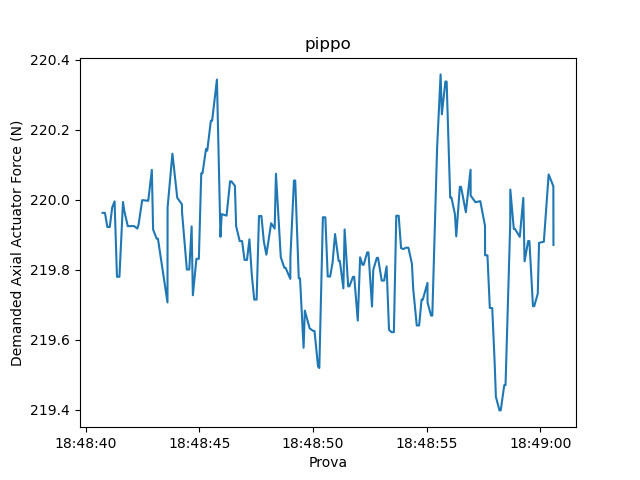

In [302]:
p_v = f_max_values - f_min_values
print(f"p_v : {p_v[3]}")


plt.figure()
plt.plot(data_act_before.measured3)

plt.title("pippo")
plt.xlabel("Prova")
plt.ylabel("Demanded Axial Actuator Force (N)")
plt.show()



In [303]:
data_act_before.measured3

2023-05-18 18:48:40.747404+00:00    219.963036
2023-05-18 18:48:40.852880+00:00    219.963036
2023-05-18 18:48:40.958790+00:00    219.922683
2023-05-18 18:48:41.065596+00:00    219.922683
2023-05-18 18:48:41.170849+00:00    219.978106
                                       ...    
2023-05-18 18:49:00.159012+00:00    219.880634
2023-05-18 18:49:00.365531+00:00    220.072746
2023-05-18 18:49:00.369908+00:00    220.072746
2023-05-18 18:49:00.577281+00:00    220.039076
2023-05-18 18:49:00.581644+00:00    219.871278
Name: measured3, Length: 192, dtype: float64

In [304]:
type(actuators)

list

In [308]:
efd_client = retrieve_efd_client(is_summit=False)


#fill a list with n actuators
n = 12
actuators = [3, 7, 11, 17, 21, 27, 30, 37, 44, 50, 58, 65]
names_actuators = ["B4", "B8", "B13", "B18", "B22", "B28", "C1", "C8", "C15", "C21", "D5", "D12"]
for idx in range(n):
    print(f"actuator: {actuators[idx]}. is {names_actuators[idx]}")

        
#bring all actuators to zero   
n_act = NUM_ACTUATOR - NUM_TANGENT_LINK
all_actuators = [0] * n_act
f_Delta = [0] * n_act
f_Delta = np.array(f_Delta, float)
forces = f_Delta

#apply force of the loop
for idx in range(n_act):
    #print(f"command fDelta to actuator: {idx}.")
    force = forces[idx]
await injectForce_axial_actuator(m2, all_actuators, f_Delta, sleep_time= 5)
  
# increase the time to at least 120 sec, bettter if 180 sec    
await asyncio.sleep(25)    

# retrieve from EFD the last 20 seconds of measured forces on actuators
time_end = datetime.now()
time_end = Time(time_end, scale="utc")
time_start = time_end - timedelta(seconds = 20)
time_start = Time(time_start, scale="utc")

names = list()
for idx in range(n_act):
    names.append(f"measured{idx}")
    
data_act_before = await efd_client.select_time_series(
        "lsst.sal.MTM2.axialForce",
        fields=names,
        start=time_start,
        end=time_end)

f_max = data_act_before.max()
f_min = data_act_before.min()
f_max_values = f_max.to_numpy()
f_min_values = f_min.to_numpy()
p_v = f_max_values - f_min_values
print(f"p_v : {p_v}")


data_measured_forces = m2.tel_axialForce.get()
#print(f"value : {data_measured_forces.measured}")

data_measured_forces_values = np.array(data_measured_forces.measured, float)


# calculate force to be applied
f_Delta = 440 - (p_v[actuators] + data_measured_forces_values[actuators])


forces = f_Delta
print(f"forces : {forces}")


#apply force of the loop
for idx in range(n):
    #print(f"command fDelta to actuator: {idx}.")
    force = forces[idx]
    print("The actuator activated is ", actuators[idx], names_actuators[idx])
await injectForce_axial_actuator(m2, actuators, f_Delta, sleep_time= 5)

# get time for starting and ending telemetry data
time_start1 = datetime.now()
time_start1 = Time(time_start1, scale="utc")
print(f"UTC time to is {time_start} now.")

await asyncio.sleep(20)    

time_end1 = datetime.now()
time_end1 = Time(time_end1, scale="utc")


print(f"time start : {time_start1}")
print(f"time end : {time_end1}")

# switch off actuators power

#wait for pushing red button
command = input("Cut the power")

# retriveve telemetry with cut power

# get time for starting and ending telemetry data
time_start2 = datetime.now()
time_start2 = Time(time_start2, scale="utc")
print(f"UTC time to is {time_start2} now.")

await asyncio.sleep(20)    

time_end2 = datetime.now()
time_end2 = Time(time_end2, scale="utc")


#retrieve telemetry
names = list()
for idx in range(72):
    names.append(f"measured{idx}")    
    
data_act = await efd_client.select_time_series(
        "lsst.sal.MTM2.axialForce",
        fields=names,
        start=time_start1,
        end=time_end2)
data_act.to_csv("actuators_data.csv")

data_power_cell = await efd_client.select_time_series(
        "lsst.sal.MTM2.powerStatus",
        fields=["motorVoltage","motorCurrent","commVoltage","commCurrent"],
        start=time_start1,
        end=time_end2)
data_power_cell.to_csv("power_data.csv")


print(f"time start : {time_start1}")
print(f"time end : {time_end2}")

command = input("Restore the power")

#bring all actuators to zero   
n_act = NUM_ACTUATOR - NUM_TANGENT_LINK
all_actuators = [0] * n_act
f_Delta = [0] * n_act
f_Delta = np.array(f_Delta, float)
forces = f_Delta

#apply force of the loop
for idx in range(n_act):
    #print(f"command fDelta to actuator: {idx}.")
    force = forces[idx]
# change the below function with MTM2_command_resetForceOffsets    
await injectForce_axial_actuator(m2, all_actuators, f_Delta, sleep_time= 5)
print("Actuators at zero")

actuator: 3. is B4
actuator: 7. is B8
actuator: 11. is B13
actuator: 17. is B18
actuator: 21. is B22
actuator: 27. is B28
actuator: 30. is C1
actuator: 37. is C8
actuator: 44. is C15
actuator: 50. is C21
actuator: 58. is D5
actuator: 65. is D12
p_v : [0.73318081 0.87336569 0.74594209 0.94510256 0.86638314 1.09574823
 0.92837232 0.82732997 1.07532288 0.79588843 0.92302473 0.98637459
 0.73523033 0.81186819 0.82496413 1.84291869 0.95761315 0.88144082
 0.70451023 0.91155506 0.84999159 1.08082798 1.02336612 0.92438989
 0.94252473 2.61030077 0.95480098 0.90501662 0.99754019 1.11547009
 0.93254872 1.02241568 0.7275772  0.76720642 0.82782437 1.0750215
 0.87478273 1.01458799 0.67048529 0.87909599 1.1524716  1.13009745
 1.20959738 0.78349834 0.69365396 0.90393375 0.72425067 0.87174953
 0.92587049 1.00194811 0.84733849 0.88105861 0.76142626 0.85418465
 1.01088053 0.85168041 0.92634342 0.92168679 0.68701807 0.94775446
 1.20468718 0.77448378 0.92594636 0.70750581 1.10945424 0.93656919
 0.93769988 0

Cut the power 


UTC time to is 2023-05-18 19:29:07.452195 now.


time start : 2023-05-18 19:26:05.272125
time end : 2023-05-18 19:29:27.454193


Restore the power 


Actuators at zero
